In [ ]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
# Mount Google Drive for dataset access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the dataset path
data_dir = '/content/drive/MyDrive/postnatal'


In [ ]:
# Check the directory
os.listdir(os.path.join(data_dir, '/content/drive/MyDrive/postnatal/downSyndorme'))

['downSyndrome']

In [ ]:
# Use ImageDataGenerator to load and augment the images
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [ ]:
# Load the dataset
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # For binary classification (Healthy or Down Syndrome)
    subset='training'  # Specify this as the training subset
)

Found 2400 images belonging to 2 classes.


In [ ]:
test_val_split = ImageDataGenerator(rescale=1./255)
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify this as the validation subset
)


Found 599 images belonging to 2 classes.


In [ ]:
# Display the number of samples in each dataset
train_samples = len(train_generator.filenames)
val_samples = len(val_generator.filenames)
print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")

Training samples: 2400
Validation samples: 599


In [ ]:

class_counts = train_generator.class_indices

# Print the corrected class counts
print(f"Class Counts: {class_counts}")

# Map to correct keys
corrected_keys = {
    'downSyndorme': 'downSyndrome',
    'healty': 'healthy'
}

# Access values using corrected keys
down_syndrome_count = class_counts.get('downSyndorme', 0)  # Default to 0 if key doesn't exist
healthy_count = class_counts.get('healty', 0)

print(f"Class 1 = Healthy: {healthy_count}, Class 0 = Down Syndrome: {down_syndrome_count}")



Class Counts: {'downSyndorme': 0, 'healty': 1}
Class 1 = Healthy: 1, Class 0 = Down Syndrome: 0


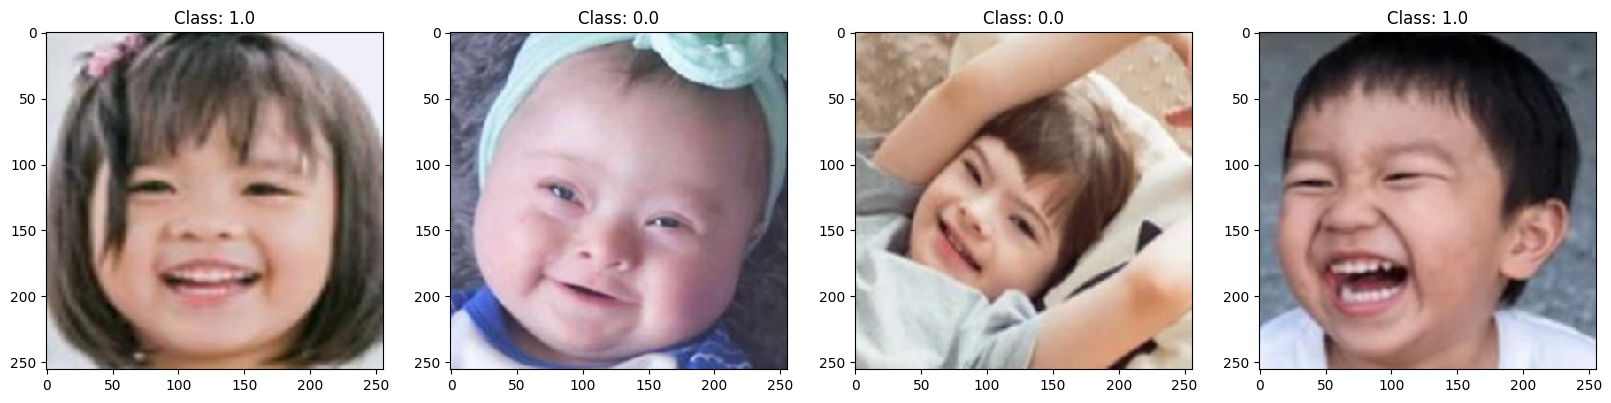

In [ ]:
# Sample some images from the training set
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Get a batch from the generator
batch = next(train_generator)  # or use 'next(train_generator)' to get the next batch

for idx, img in enumerate(batch[0][:4]):  # batch[0] is the image data
    ax[idx].imshow(img)
    ax[idx].title.set_text(f"Class: {batch[1][idx]}")  # batch[1] contains the labels

plt.show()


In [ ]:
# Define CNN Model
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.3),

        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile Model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Instantiate Model
CNN_model = create_cnn_model()

# Print Model Summary
CNN_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      2

In [ ]:
# Callbacks for Overfitting Prevention
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the Model
history = CNN_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
71/75 [===========================>..] - ETA: 25s - loss: 19.5973 - accuracy: 0.6378

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


75/75 [==============================] - 571s 8s/step - loss: 19.2455 - accuracy: 0.6375 - val_loss: 44.3163 - val_accuracy: 0.4992 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 453s 6s/step - loss: 9.5369 - accuracy: 0.6942 - val_loss: 14.2088 - val_accuracy: 0.5142 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 451s 6s/step - loss: 5.0728 - accuracy: 0.7121 - val_loss: 7.7153 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 453s 6s/step - loss: 2.9349 - accuracy: 0.7471 - val_loss: 3.3061 - val_accuracy: 0.5392 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 454s 6s/step - loss: 1.9871 - accuracy: 0.7517 - val_loss: 2.2432 - val_accuracy: 0.5860 - lr: 0.0010
Epoch 6/20
75/75 [==============================] - 453s 6s/step - loss: 1.6509 - accuracy: 0.7412 - val_loss: 2.3175 - val_accuracy: 0.5893 - lr: 0.0010
Epoch 7/20
75/75 [==============================] - 453s 6s/step - loss: 1.5535 - ac

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import label_binarize

# 1. Evaluate the model on the validation data
test_loss, test_acc = CNN_model.evaluate(val_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# 2. Save the model
CNN_model.save('cnn_down_syndrome_model.h5')
print("Model saved as 'cnn_down_syndrome_model.h5'")





19/19 [==============================] - 25s 1s/step - loss: 1.1554 - accuracy: 0.7730
Test Loss: 1.155414342880249, Test Accuracy: 0.7729549407958984


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'cnn_down_syndrome_model.h5'


1/1 [==============================] - 1s 967ms/step

Classification Report:
              precision    recall  f1-score   support

downSyndorme       0.74      0.85      0.79       300
      healty       0.82      0.70      0.75       299

    accuracy                           0.77       599
   macro avg       0.78      0.77      0.77       599
weighted avg       0.78      0.77      0.77       599



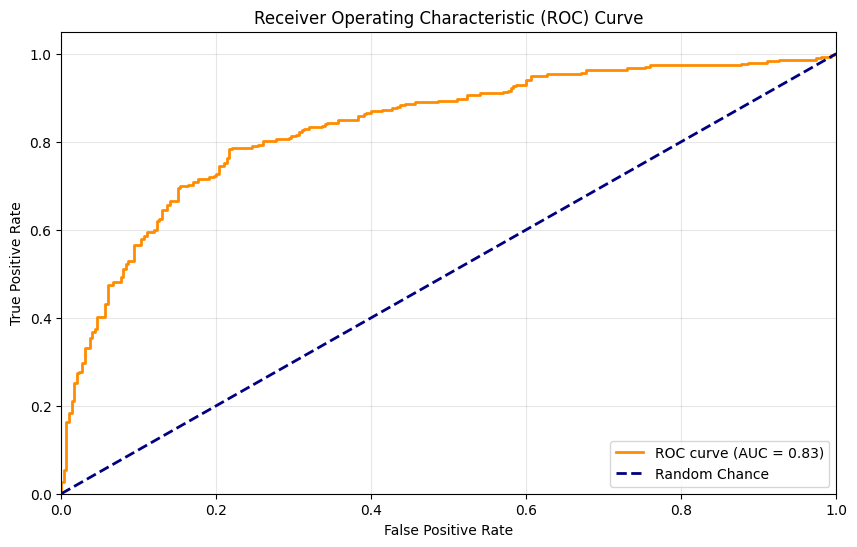

In [ ]:
# Calculate the number of batches
num_batches = len(val_generator)  # Total batches in the validation set

# Initialize lists for true labels and predicted probabilities
y_true = []
y_pred_prob = []

# Loop through the validation data (finite loop)
for i in range(num_batches):
    X, y = next(val_generator)  # Get a batch of data
    y_true.extend(y)  # Collect true labels
    predictions = CNN_model.predict(X)  # Predict probabilities for batch
    y_pred_prob.extend(predictions.flatten())  # Store predicted probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# 4. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_generator.class_indices.keys())))

# 5. ROC Curve Plot
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

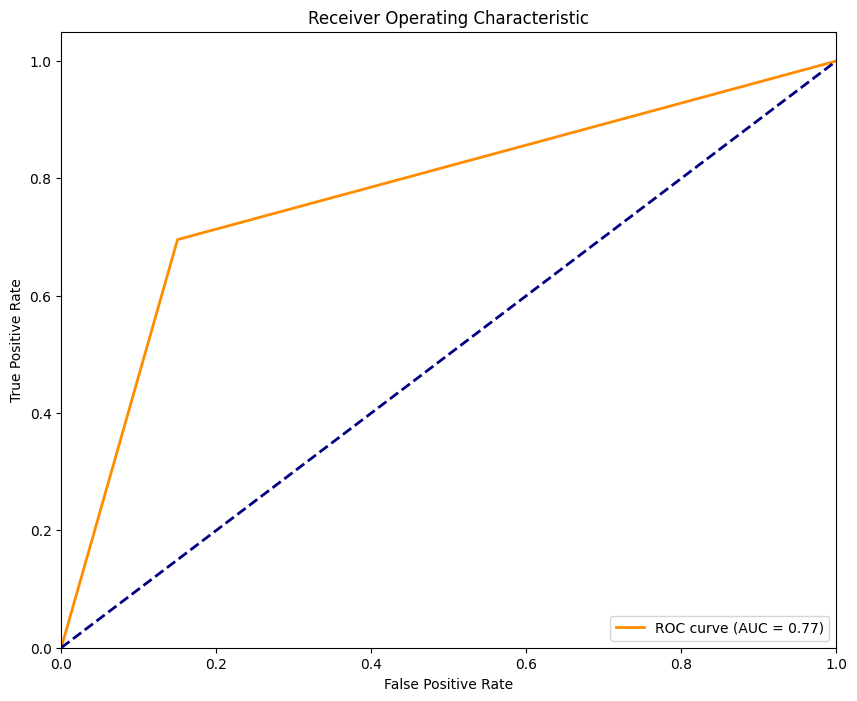

AUC: 0.77


In [ ]:
# 5. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 6. AUC Score
print(f"AUC: {roc_auc:.2f}")
